## Import Liabraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import cv2
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2024-04-22 16:02:20.133761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 16:02:20.133860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 16:02:20.225610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load data

In [2]:
data = '/kaggle/input/utk-face-cropped/utkcropped'

In [3]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(data)):
    image_path = os.path.join(data, filename)
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
    except ValueError:
        print("Skipping file:", filename)
        continue
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23710 [00:00<?, ?it/s]

Skipping file: utkcropped


In [4]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utk-face-cropped/utkcropped/26_0...,26,0
1,/kaggle/input/utk-face-cropped/utkcropped/22_1...,22,1
2,/kaggle/input/utk-face-cropped/utkcropped/21_1...,21,1
3,/kaggle/input/utk-face-cropped/utkcropped/28_0...,28,0
4,/kaggle/input/utk-face-cropped/utkcropped/17_1...,17,1


In [5]:
# Map labels for gender

gender_dict = {0:'Male', 1:'Female'}

## EDA

Image Shape:  (200, 200, 3)


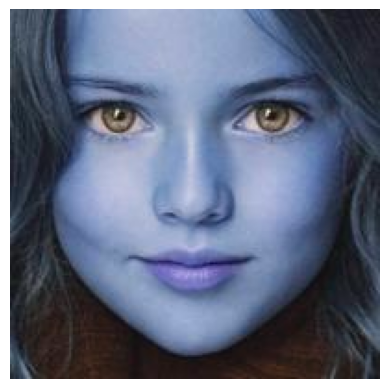

In [6]:
img = cv2.imread('/kaggle/input/utk-face-cropped/utkcropped/10_1_0_20170109203438428.jpg.chip.jpg')
plt.axis('off')
plt.imshow(img);
print('Image Shape: ',img.shape)

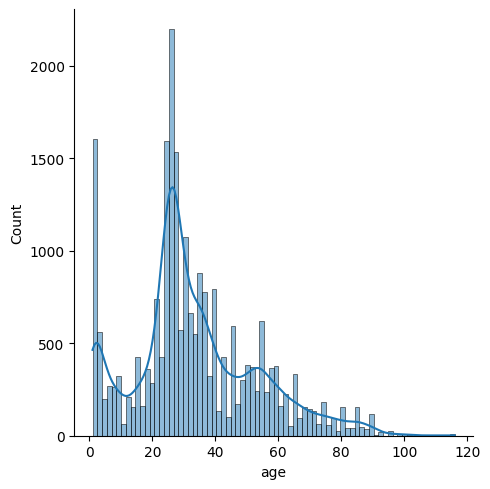

In [7]:
sns.displot(df['age'],kde = True);

gender
0    12391
1    11317
3        1
Name: count, dtype: int64


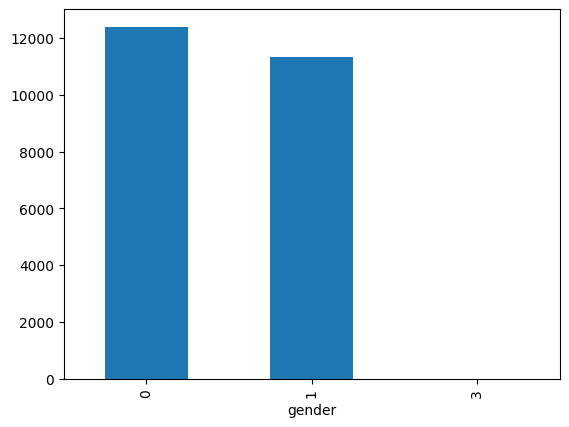

In [8]:
print(df['gender'].value_counts())
df['gender'].value_counts().plot(kind='bar');

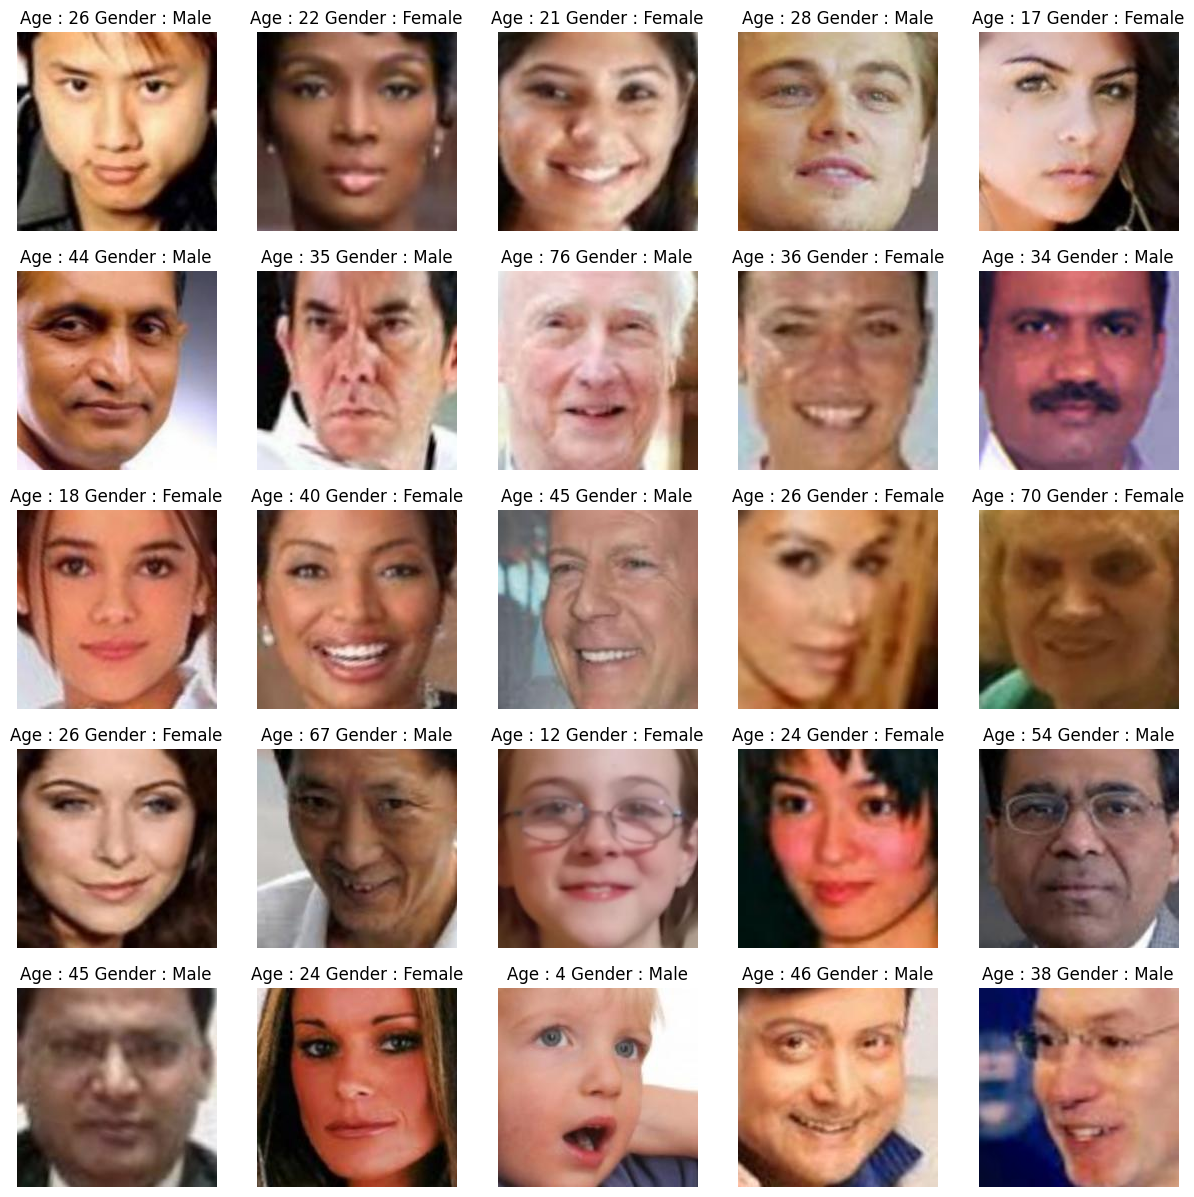

In [9]:
# Display grid/multiple images

plt.figure(figsize=(15,15))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'Age : {age} Gender : {gender_dict[gender]}')
    plt.axis('off')

## Feature Extraction

In [10]:
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/23709 [00:00<?, ?it/s]

In [12]:
print(X.shape)

(23709, 128, 128, 1)


In [13]:
# Normalize the images

X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128,128,1)

## Building Model

In [16]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

conv_4 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout_2)

model = Model(inputs = [inputs], outputs = [output_1, output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy','mae'])

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    295,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    295,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 618,914 (2.36 MB)

 Trainable params: 618,914 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [18]:
history = model.fit(x = X, y = [y_gender, y_age], batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
 13/593 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - age_out_mae: 33.9508 - gender_out_accuracy: 0.4931 - loss: 34.6597

I0000 00:00:1713801968.650195      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713801968.670446      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_out_mae: 17.5868 - gender_out_accuracy: 0.5318 - loss: 18.2897

W0000 00:00:1713801980.305865      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713801981.762572      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - age_out_mae: 17.5831 - gender_out_accuracy: 0.5319 - loss: 18.2860 - val_age_out_mae: 13.4710 - val_gender_out_accuracy: 0.7098 - val_loss: 14.0382
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 12.6477 - gender_out_accuracy: 0.7268 - loss: 13.2021 - val_age_out_mae: 10.8305 - val_gender_out_accuracy: 0.7720 - val_loss: 11.3115
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - age_out_mae: 10.7529 - gender_out_accuracy: 0.7657 - loss: 11.2369 - val_age_out_mae: 11.0753 - val_gender_out_accuracy: 0.7737 - val_loss: 11.5599
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 10.0846 - gender_out_accuracy: 0.7868 - loss: 10.5329 - val_age_out_mae: 9.2805 - val_gender_out_accuracy: 0.8043 - val_loss: 9.7064
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 9.3452 - gender_out_accuracy: 0.8013 - loss: 9.7719 - val_age_out_mae: 8.9009 - val_gender_out_accuracy: 0.8277 - val_loss: 9.2973
E

## Plot the Results

<Figure size 640x480 with 0 Axes>

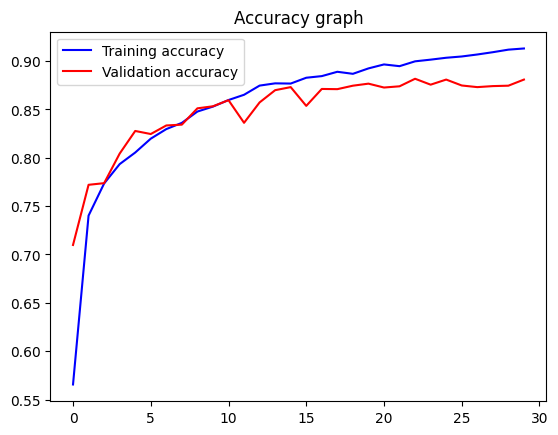

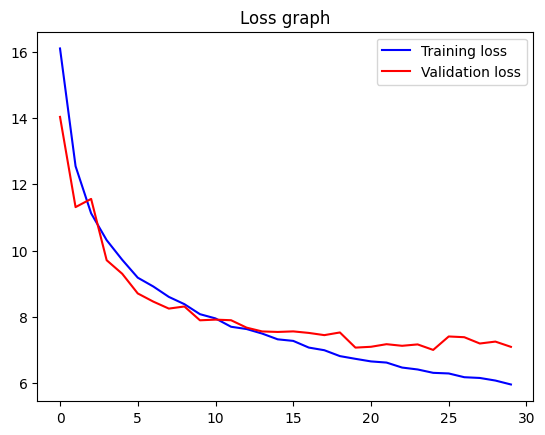

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Loss graph')
plt.legend()
plt.figure()

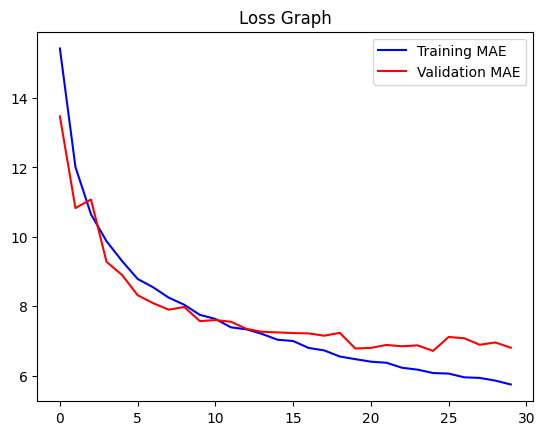

In [20]:
# Plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Model evaluation

Original Gender: Female Original Age: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
Predicted Gender: Female Predicted Age: 26


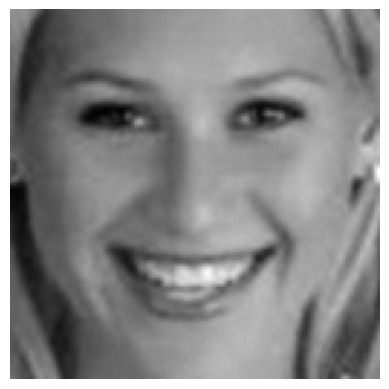

In [21]:
image_index = 103
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 26


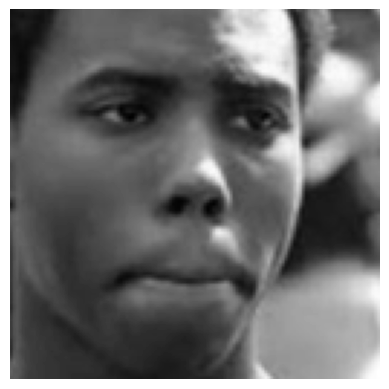

In [22]:
image_index = 10008
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Male Predicted Age: 29


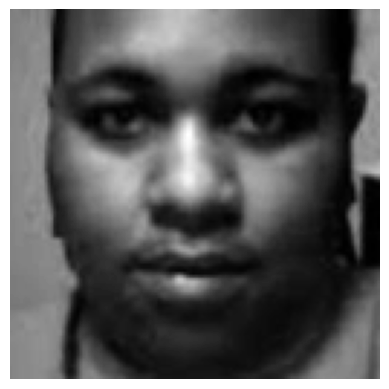

In [23]:
image_index = 23599
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

# Thank You!